# Random Forest Model - HDB Resale Price Prediction

This notebook implements a Random Forest model to predict Singapore HDB resale prices.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from util.preprocess import preprocess as test_preprocess
import util.geo_data as geo
from importlib import reload
reload(geo)
import warnings
warnings.filterwarnings('ignore')


## 1. Data Loading and Initial Analysis


In [2]:
# Load raw train and test data (unified preprocessing + geo features)
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
print("\nTrain columns:")
print(df_train.columns.tolist())


Train shape: (162691, 11)
Test shape: (50000, 10)

Train columns:
['MONTH', 'TOWN', 'FLAT_TYPE', 'BLOCK', 'STREET', 'FLOOR_RANGE', 'FLOOR_AREA_SQM', 'FLAT_MODEL', 'ECO_CATEGORY', 'LEASE_COMMENCE_DATA', 'RESALE_PRICE']


In [3]:
# Inspect basic data info
print("Train info:")
print(df_train.info())
print("\nTrain head:")
print(df_train.head())


Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162691 entries, 0 to 162690
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   MONTH                162691 non-null  object 
 1   TOWN                 162691 non-null  object 
 2   FLAT_TYPE            162691 non-null  object 
 3   BLOCK                162691 non-null  object 
 4   STREET               162691 non-null  object 
 5   FLOOR_RANGE          162691 non-null  object 
 6   FLOOR_AREA_SQM       162691 non-null  float64
 7   FLAT_MODEL           162691 non-null  object 
 8   ECO_CATEGORY         162691 non-null  object 
 9   LEASE_COMMENCE_DATA  162691 non-null  int64  
 10  RESALE_PRICE         162691 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 13.7+ MB
None

Train head:
     MONTH           TOWN FLAT_TYPE BLOCK              STREET FLOOR_RANGE  \
0  2020-10      woodlands    4 room  681B  woodlands dri

Missing values summary:
MONTH                  0
TOWN                   0
FLAT_TYPE              0
BLOCK                  0
STREET                 0
FLOOR_RANGE            0
FLOOR_AREA_SQM         0
FLAT_MODEL             0
ECO_CATEGORY           0
LEASE_COMMENCE_DATA    0
RESALE_PRICE           0
dtype: int64


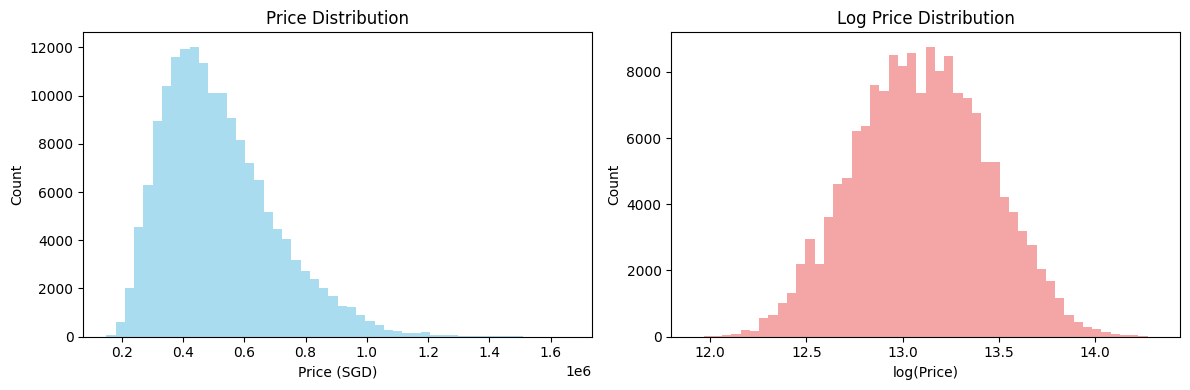

In [4]:
# Check missing values
print("Missing values summary:")
print(df_train.isnull().sum())

# Target variable distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df_train['RESALE_PRICE'], bins=50, alpha=0.7, color='skyblue')
plt.title('Price Distribution')
plt.xlabel('Price (SGD)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(np.log(df_train['RESALE_PRICE']), bins=50, alpha=0.7, color='lightcoral')
plt.title('Log Price Distribution')
plt.xlabel('log(Price)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


## 2. Feature Engineering and Data Preparation


In [5]:
# Unified preprocessing for training data with geographic features
print("Start preprocessing training data...")
train_pre = test_preprocess(df_train)
print("Adding geographic features...")

train_pre_geo = geo.add_geo_data(train_pre[['TOWN','BLOCK','STREET','FLOOR_AREA_SQM','LEASE_COMMENCE_DATA','RESALE_YEAR','RESALE_MONTH','FLOOR_AVG','FLAT_TYPE']].copy())

# Ensure required geographic feature columns exist; if missing, print columns for debugging
required_geo_cols = [
    'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M',
    'DIST_TO_NEAREST_PRIMARY_SCHOOL_M', 'DIST_TO_NEAREST_SECONDARY_SCHOOL_M',
    'NUM_PRIMARY_SCHOOLS_500M', 'NUM_PRIMARY_SCHOOLS_1000M',
    'NUM_SECONDARY_SCHOOLS_500M', 'NUM_SECONDARY_SCHOOLS_1000M'
]
missing_cols = [c for c in required_geo_cols if c not in train_pre_geo.columns]
if missing_cols:
    print(f"[Warning] Missing geo feature columns: {missing_cols}")
    print(f"Available columns (sample): {train_pre_geo.columns.tolist()[:50]}")

# Derive AGE, YEAR, MONTH
train_pre_geo['YEAR'] = train_pre_geo['RESALE_YEAR']
train_pre_geo['MONTH'] = train_pre_geo['RESALE_MONTH']
train_pre_geo['AGE'] = train_pre_geo['YEAR'] - train_pre_geo['LEASE_COMMENCE_DATA']

# Encode TOWN and FLAT_TYPE

town_mapping = {
    'ang mo kio': 1, 'bedok': 2, 'bishan': 3, 'bukit batok': 4, 'bukit merah': 5,
    'bukit panjang': 6, 'bukit timah': 7, 'central area': 8, 'choa chu kang': 9,
    'clementi': 10, 'geylang': 11, 'hougang': 12, 'jurong east': 13, 'jurong west': 14,
    'kallang/whampoa': 15, 'marine parade': 16, 'pasir ris': 17, 'punggol': 18,
    'queenstown': 19, 'sembawang': 20, 'sengkang': 21, 'serangoon': 22,
    'tampines': 23, 'toa payoh': 24, 'woodlands': 25, 'yishun': 26
}
train_pre_geo['TOWN_ENCODED'] = train_pre_geo['TOWN'].str.lower().map(town_mapping)

def encode_flat_type(flat_type):
    flat_type = flat_type.lower().strip()
    if '1 room' in flat_type or '1-room' in flat_type:
        return 1
    elif '2 room' in flat_type or '2-room' in flat_type:
        return 2
    elif '3 room' in flat_type or '3-room' in flat_type:
        return 3
    elif '4 room' in flat_type or '4-room' in flat_type:
        return 4
    elif '5 room' in flat_type or '5-room' in flat_type:
        return 5
    elif 'executive' in flat_type:
        return 10
    elif 'multi generation' in flat_type:
        return 11
    else:
        return 3
train_pre_geo['FLAT_TYPE_ENCODED'] = train_pre_geo['FLAT_TYPE'].apply(encode_flat_type)

# Select feature columns (include geo features + school distance and density)
feature_columns = [
    'YEAR', 'MONTH', 'TOWN_ENCODED', 'FLAT_TYPE_ENCODED',
    'FLOOR_AVG', 'FLOOR_AREA_SQM', 'LEASE_COMMENCE_DATA', 'AGE',
    'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M',
    'DIST_TO_NEAREST_PRIMARY_SCHOOL_M', 'DIST_TO_NEAREST_SECONDARY_SCHOOL_M',
    'NUM_PRIMARY_SCHOOLS_500M', 'NUM_PRIMARY_SCHOOLS_1000M',
    'NUM_SECONDARY_SCHOOLS_500M', 'NUM_SECONDARY_SCHOOLS_1000M'
]

X = train_pre_geo[feature_columns]
y = df_train['RESALE_PRICE']

print("Feature columns:", feature_columns)
print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)


Start preprocessing training data...
Adding geographic features...
[geo] Coordinate hits: 162691/162691 (100.00%), missing: 0
Feature columns: ['YEAR', 'MONTH', 'TOWN_ENCODED', 'FLAT_TYPE_ENCODED', 'FLOOR_AVG', 'FLOOR_AREA_SQM', 'LEASE_COMMENCE_DATA', 'AGE', 'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M', 'DIST_TO_NEAREST_PRIMARY_SCHOOL_M', 'DIST_TO_NEAREST_SECONDARY_SCHOOL_M', 'NUM_PRIMARY_SCHOOLS_500M', 'NUM_PRIMARY_SCHOOLS_1000M', 'NUM_SECONDARY_SCHOOLS_500M', 'NUM_SECONDARY_SCHOOLS_1000M']
Feature matrix shape: (162691, 17)
Target shape: (162691,)


In [6]:
# Check feature dtypes
print("Feature dtypes:")
print(X.dtypes)

# Check for missing values
print("\nFeature missing values:")
print(X.isnull().sum())


Feature dtypes:
YEAR                                    int64
MONTH                                   int64
TOWN_ENCODED                            int64
FLAT_TYPE_ENCODED                       int64
FLOOR_AVG                               int64
FLOOR_AREA_SQM                        float64
LEASE_COMMENCE_DATA                     int64
AGE                                     int64
DIST_TO_NEAREST_MRT_M                 float64
DIST_TO_NEAREST_HAWKER_M              float64
DIST_TO_NEAREST_SHOP_M                float64
DIST_TO_NEAREST_PRIMARY_SCHOOL_M      float64
DIST_TO_NEAREST_SECONDARY_SCHOOL_M    float64
NUM_PRIMARY_SCHOOLS_500M                int64
NUM_PRIMARY_SCHOOLS_1000M               int64
NUM_SECONDARY_SCHOOLS_500M              int64
NUM_SECONDARY_SCHOOLS_1000M             int64
dtype: object

Feature missing values:
YEAR                                  0
MONTH                                 0
TOWN_ENCODED                          0
FLAT_TYPE_ENCODED                     0
FLO

## 3. Random Forest Training


In [7]:
# Split train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size: {X_train.shape}")
print(f"Validation size: {X_val.shape}")


Train size: (130152, 17)
Validation size: (32539, 17)


In [8]:
# Create baseline RandomForest model
rf_basic = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# Train model
rf_basic.fit(X_train, y_train)

# Predict
y_pred_train = rf_basic.predict(X_train)
y_pred_val = rf_basic.predict(X_val)

# Evaluate metrics
print("=== Baseline Random Forest Performance ===")
print(f"Train R²: {r2_score(y_train, y_pred_train):.4f}")
print(f"Validation R²: {r2_score(y_val, y_pred_val):.4f}")
print(f"Train MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"Validation MAE: {mean_absolute_error(y_val, y_pred_val):.2f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")
print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_val)):.2f}")


=== Baseline Random Forest Performance ===
Train R²: 0.9956
Validation R²: 0.9688
Train MAE: 8240.27
Validation MAE: 21935.93
Train RMSE: 12175.78
Validation RMSE: 32254.15


## 4. Hyperparameter Tuning


In [ ]:
# Define a wider parameter distribution (random search)
param_distributions = {
    'n_estimators': np.arange(200, 1201, 50),
    'max_depth': [None] + list(np.arange(8, 41, 2)),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 11),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Create RandomForest model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Randomized search (increase resolution/diversity; mitigate overfitting)
print("Start randomized hyperparameter search...")
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=80,  # increase if you have more time
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

# Safely get best params/score from random_search or fallback to hardcoded values
try:
    first_tuning_best_params = random_search.best_params_
    first_tuning_best_score = -random_search.best_score_
except Exception:
    import numpy as np
    first_tuning_best_params = {
        'n_estimators': np.int64(850),
        'min_samples_split': np.int64(2),
        'min_samples_leaf': np.int64(2),
        'max_features': 'log2',
        'max_depth': np.int64(40),
        'bootstrap': True,
    }
    first_tuning_best_score = 1081850751.0560

print("\nBest parameters:")
print(first_tuning_best_params)
print(f"\nBest CV MSE: {first_tuning_best_score:.4f}")


Start randomized hyperparameter search...
Fitting 5 folds for each of 80 candidates, totalling 400 fits

Best parameters:
{'n_estimators': np.int64(850), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(2), 'max_features': 'log2', 'max_depth': np.int64(40), 'bootstrap': True}

Best CV MSE: 1081850751.0560


In [10]:
# Train final model with the best parameters
best_rf = random_search.best_estimator_

# Evaluate on validation set
y_pred_best = best_rf.predict(X_val)

print("=== Tuned Random Forest Performance ===")
print(f"Validation R²: {r2_score(y_val, y_pred_best):.4f}")
print(f"Validation MAE: {mean_absolute_error(y_val, y_pred_best):.2f}")
print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_best)):.2f}")


=== Tuned Random Forest Performance ===
Validation R²: 0.9701
Validation MAE: 21857.05
Validation RMSE: 31566.05


## 5. Feature Importance Analysis


Feature importance (sorted):
                               feature  importance
5                       FLOOR_AREA_SQM    0.224058
3                    FLAT_TYPE_ENCODED    0.167580
0                                 YEAR    0.145582
9             DIST_TO_NEAREST_HAWKER_M    0.089975
6                  LEASE_COMMENCE_DATA    0.089947
7                                  AGE    0.059748
4                            FLOOR_AVG    0.055334
2                         TOWN_ENCODED    0.045327
8                DIST_TO_NEAREST_MRT_M    0.027742
10              DIST_TO_NEAREST_SHOP_M    0.027622
12  DIST_TO_NEAREST_SECONDARY_SCHOOL_M    0.016537
11    DIST_TO_NEAREST_PRIMARY_SCHOOL_M    0.015022
14           NUM_PRIMARY_SCHOOLS_1000M    0.014310
16         NUM_SECONDARY_SCHOOLS_1000M    0.009340
1                                MONTH    0.004558
13            NUM_PRIMARY_SCHOOLS_500M    0.004041
15          NUM_SECONDARY_SCHOOLS_500M    0.003278


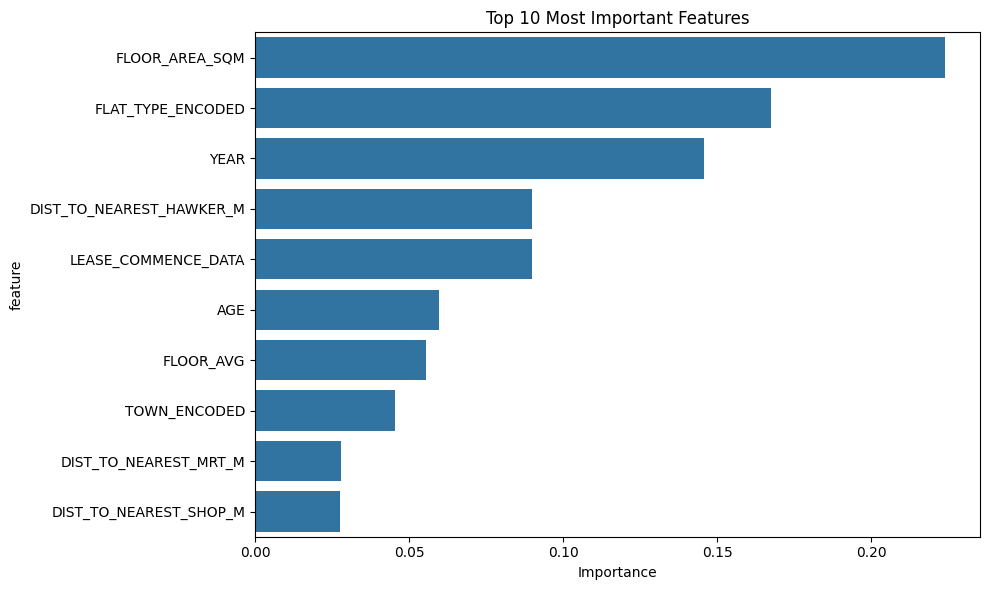

In [11]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature importance (sorted):")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


## 6. Model Performance Visualization


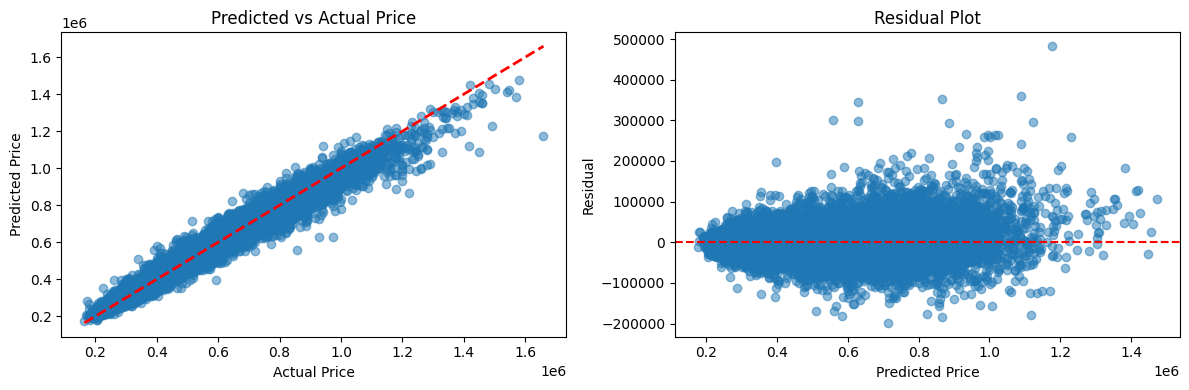

In [12]:
# Visualizations using existing y_val and y_pred_best from upstream cells
plt.figure(figsize=(12, 4))

# Predicted vs Actual
plt.subplot(1, 2, 1)
plt.scatter(y_val, y_pred_best, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Price')

# Residual plot
plt.subplot(1, 2, 2)
residuals = y_val - y_pred_best
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residual')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()


In [1]:
# Refined search based on first tuning (build on previous results)
# Reason: The notebook did not complete a clean run previously.
# This cell adds safe bootstrapping so we can start from here if upstream cells were not executed.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from util.preprocess import preprocess as test_preprocess
import util.geo_data as geo

# 1) df_train / df_test
if 'df_train' not in globals() or 'df_test' not in globals():
    print('[AutoInit] Loading raw df_train / df_test ...')
    df_train = pd.read_csv('../data/train.csv')
    df_test = pd.read_csv('../data/test.csv')

# 2) train_pre
if 'train_pre' not in globals():
    print('[AutoInit] Running preprocessing to get train_pre ...')
    train_pre = test_preprocess(df_train)

# 3) train_pre_geo, encodings, X / y
if 'train_pre_geo' not in globals() or 'X' not in globals() or 'y' not in globals():
    print('[AutoInit] Building geo features and encodings to create X / y ...')
    train_pre_geo = geo.add_geo_data(
        train_pre[['TOWN','BLOCK','STREET','FLOOR_AREA_SQM','LEASE_COMMENCE_DATA','RESALE_YEAR','RESALE_MONTH','FLOOR_AVG','FLAT_TYPE']].copy()
    )
    # Derived columns
    train_pre_geo['YEAR'] = train_pre_geo['RESALE_YEAR']
    train_pre_geo['MONTH'] = train_pre_geo['RESALE_MONTH']
    train_pre_geo['AGE'] = train_pre_geo['YEAR'] - train_pre_geo['LEASE_COMMENCE_DATA']

    # Encoding (keep variable names consistent with upstream cells)
    town_mapping = {
        'ang mo kio': 1, 'bedok': 2, 'bishan': 3, 'bukit batok': 4, 'bukit merah': 5,
        'bukit panjang': 6, 'bukit timah': 7, 'central area': 8, 'choa chu kang': 9,
        'clementi': 10, 'geylang': 11, 'hougang': 12, 'jurong east': 13, 'jurong west': 14,
        'kallang/whampoa': 15, 'marine parade': 16, 'pasir ris': 17, 'punggol': 18,
        'queenstown': 19, 'sembawang': 20, 'sengkang': 21, 'serangoon': 22,
        'tampines': 23, 'toa payoh': 24, 'woodlands': 25, 'yishun': 26
    }
    def encode_flat_type(flat_type):
        ft = str(flat_type).lower().strip()
        if '1 room' in ft or '1-room' in ft:
            return 1
        elif '2 room' in ft or '2-room' in ft:
            return 2
        elif '3 room' in ft or '3-room' in ft:
            return 3
        elif '4 room' in ft or '4-room' in ft:
            return 4
        elif '5 room' in ft or '5-room' in ft:
            return 5
        elif 'executive' in ft:
            return 10
        elif 'multi generation' in ft:
            return 11
        else:
            return 3
    train_pre_geo['TOWN_ENCODED'] = train_pre_geo['TOWN'].str.lower().map(town_mapping)
    train_pre_geo['FLAT_TYPE_ENCODED'] = train_pre_geo['FLAT_TYPE'].apply(encode_flat_type)

    feature_columns = [
        'YEAR', 'MONTH', 'TOWN_ENCODED', 'FLAT_TYPE_ENCODED',
        'FLOOR_AVG', 'FLOOR_AREA_SQM', 'LEASE_COMMENCE_DATA', 'AGE',
        'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M',
        'DIST_TO_NEAREST_PRIMARY_SCHOOL_M', 'DIST_TO_NEAREST_SECONDARY_SCHOOL_M',
        'NUM_PRIMARY_SCHOOLS_500M', 'NUM_PRIMARY_SCHOOLS_1000M',
        'NUM_SECONDARY_SCHOOLS_500M', 'NUM_SECONDARY_SCHOOLS_1000M'
    ]
    X = train_pre_geo[feature_columns]
    y = df_train['RESALE_PRICE']

# 4) train/validation split
if 'X_train' not in globals() or 'y_train' not in globals():
    print('[AutoInit] Creating train/validation split X_train / y_train / X_val / y_val ...')
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Best params from first tuning:")
try:
    first_tuning_best_params
    first_tuning_best_score
except NameError:
    try:
        first_tuning_best_params = random_search.best_params_
        first_tuning_best_score = -random_search.best_score_
    except Exception:
        import numpy as np
        first_tuning_best_params = {
            'n_estimators': np.int64(850),
            'min_samples_split': np.int64(2),
            'min_samples_leaf': np.int64(2),
            'max_features': 'log2',
            'max_depth': np.int64(40),
            'bootstrap': True,
        }
        first_tuning_best_score = 1081850751.0560
print(first_tuning_best_params)
print(f"First tuning CV MSE: {first_tuning_best_score:.4f}")

from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

def build_refined_rf_random_search(best_params, random_state: int = 42,
                                  n_iter: int = 60,
                                  cv: int = 5,
                                  scoring: str = 'neg_mean_squared_error',
                                  n_jobs: int = 2,
                                  verbose: int = 2) -> RandomizedSearchCV:
    """Create a refined search around the best values from the first tuning.
    Resource-limited: fewer parallel jobs, avoid refit, and controlled pre-dispatch for lower memory use.
    """
    param_distributions = {
        'n_estimators': randint(max(300, int(best_params['n_estimators']) - 150),
                                min(1000, int(best_params['n_estimators']) + 150)),
        'max_depth': randint(max(10, int(best_params['max_depth']) - 10),
                             min(50, int(best_params['max_depth']) + 10)),
        'min_samples_split': randint(max(2, int(best_params['min_samples_split']) - 2),
                                     min(10, int(best_params['min_samples_split']) + 3)),
        'min_samples_leaf': randint(max(1, int(best_params['min_samples_leaf']) - 1),
                                    min(5, int(best_params['min_samples_leaf']) + 2)),
        'max_features': [best_params['max_features']],
        'bootstrap': [best_params['bootstrap']],
    }

    rf = RandomForestRegressor(random_state=random_state, n_jobs=n_jobs)

    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        verbose=verbose,
        random_state=random_state,
        refit=False,
        pre_dispatch='2*n_jobs',
    )
    return search

print("\nStart refined search (based on first tuning)...")
refined_search = build_refined_rf_random_search(
    first_tuning_best_params,
    random_state=42,
    n_iter=60,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=2,  # limit parallel workers to reduce memory footprint
    verbose=2,
)
refined_search.fit(X_train, y_train)

print("\nBest parameters from refined search:")
print(refined_search.best_params_)
print(f"Best CV MSE from refined search: {-refined_search.best_score_:.4f}")

print(f"\n=== Tuning Results Comparison ===")
print(f"First tuning CV MSE: {first_tuning_best_score:.4f}")
print(f"Refined search CV MSE: {-refined_search.best_score_:.4f}")
# Keep improvement in the same (neg-MSE) space as before
improvement = (-first_tuning_best_score) - refined_search.best_score_
print(f"Improvement: {improvement:.4f}")

# Save and release search object to free memory
final_best_params = refined_search.best_params_
import gc
try:
    del refined_search
except Exception:
    pass
_ = gc.collect()


[AutoInit] Loading raw df_train / df_test ...
[AutoInit] Running preprocessing to get train_pre ...
[AutoInit] Building geo features and encodings to create X / y ...
[geo] Coordinate hits: 162691/162691 (100.00%), missing: 0
[AutoInit] Creating train/validation split X_train / y_train / X_val / y_val ...
Best params from first tuning:
{'n_estimators': np.int64(850), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(2), 'max_features': 'log2', 'max_depth': np.int64(40), 'bootstrap': True}
First tuning CV MSE: 1081850751.0560

Start refined search (based on first tuning)...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=806; total time= 1.2min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=806; total time= 1.2min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_lea

/Users/guetta/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/NUS_Academic/KDDM/gp/cs5228_project-main/cs5228_project-main/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=806; total time= 1.1min
[CV] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=802; total time= 1.3min
[CV] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=802; total time= 1.3min
[CV] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=802; total time= 1.3min
[CV] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=802; total time= 1.3min
[CV] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=802; total time= 1.3min
[CV] END bootstrap=True, max_depth=48, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=787; total time=  58.5s
[CV] END bootstrap=True, max_depth=48, max_featu

## 7. Cross-Validation Evaluation


In [1]:
# 7. Cross-validation (self-contained). Re-imports and rebuilds data if upstream wasn't run due to previous OOM; limits threads to avoid memory spikes.
# This cell is intentionally self-contained so the notebook can start from here even after an interrupted run.
import os, gc
import numpy as np
import pandas as pd
from joblib import parallel_backend
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, train_test_split

# Thread/parallel limits to avoid BLAS/OMP over-parallelization and high memory usage
os.environ.setdefault('OMP_NUM_THREADS', '1')
os.environ.setdefault('OPENBLAS_NUM_THREADS', '1')
os.environ.setdefault('MKL_NUM_THREADS', '1')
os.environ.setdefault('VECLIB_MAXIMUM_THREADS', '1')
os.environ.setdefault('NUMEXPR_NUM_THREADS', '1')

# Data prep: if X/y are missing, auto-build them (same columns/encodings as upstream)
if 'X' not in globals() or 'y' not in globals():
    print('[Info] Upstream cells not detected as run; auto-loading data and building X/y …')
    # Lazy imports to avoid loading when unused
    from util.preprocess import preprocess as test_preprocess
    import util.geo_data as geo

    df_train = pd.read_csv('../data/train.csv')
    train_pre = test_preprocess(df_train)

    # Geo and derived features
    train_pre_geo = geo.add_geo_data(train_pre[['TOWN','BLOCK','STREET','FLOOR_AREA_SQM','LEASE_COMMENCE_DATA','RESALE_YEAR','RESALE_MONTH','FLOOR_AVG','FLAT_TYPE']].copy())
    train_pre_geo['YEAR'] = train_pre_geo['RESALE_YEAR']
    train_pre_geo['MONTH'] = train_pre_geo['RESALE_MONTH']
    train_pre_geo['AGE'] = train_pre_geo['YEAR'] - train_pre_geo['LEASE_COMMENCE_DATA']

    # Encodings (kept consistent with upstream)
    town_mapping = {
        'ang mo kio': 1, 'bedok': 2, 'bishan': 3, 'bukit batok': 4, 'bukit merah': 5,
        'bukit panjang': 6, 'bukit timah': 7, 'central area': 8, 'choa chu kang': 9,
        'clementi': 10, 'geylang': 11, 'hougang': 12, 'jurong east': 13, 'jurong west': 14,
        'kallang/whampoa': 15, 'marine parade': 16, 'pasir ris': 17, 'punggol': 18,
        'queenstown': 19, 'sembawang': 20, 'sengkang': 21, 'serangoon': 22,
        'tampines': 23, 'toa payoh': 24, 'woodlands': 25, 'yishun': 26
    }
    def encode_flat_type(flat_type):
        ft = str(flat_type).lower().strip()
        if '1 room' in ft or '1-room' in ft:
            return 1
        elif '2 room' in ft or '2-room' in ft:
            return 2
        elif '3 room' in ft or '3-room' in ft:
            return 3
        elif '4 room' in ft or '4-room' in ft:
            return 4
        elif '5 room' in ft or '5-room' in ft:
            return 5
        elif 'executive' in ft:
            return 10
        elif 'multi generation' in ft:
            return 11
        else:
            return 3

    train_pre_geo['TOWN_ENCODED'] = train_pre_geo['TOWN'].str.lower().map(town_mapping)
    train_pre_geo['FLAT_TYPE_ENCODED'] = train_pre_geo['FLAT_TYPE'].apply(encode_flat_type)

    feature_columns = [
        'YEAR', 'MONTH', 'TOWN_ENCODED', 'FLAT_TYPE_ENCODED',
        'FLOOR_AVG', 'FLOOR_AREA_SQM', 'LEASE_COMMENCE_DATA', 'AGE',
        'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M',
        'DIST_TO_NEAREST_PRIMARY_SCHOOL_M', 'DIST_TO_NEAREST_SECONDARY_SCHOOL_M',
        'NUM_PRIMARY_SCHOOLS_500M', 'NUM_PRIMARY_SCHOOLS_1000M',
        'NUM_SECONDARY_SCHOOLS_500M', 'NUM_SECONDARY_SCHOOLS_1000M'
    ]
    X = train_pre_geo[feature_columns]
    y = df_train['RESALE_PRICE']
    print(f'[OK] Built: X shape = {X.shape}, y shape = {y.shape}')

print(f"Data for cross-validation: X = {X.shape}, y = {y.shape}")

# Best params: prefer refined_search/random_search; fallback to safe defaults if absent
if 'final_best_params' in globals():
    best_params_for_cv = final_best_params.copy()
elif 'refined_search' in globals() and hasattr(refined_search, 'best_params_'):
    best_params_for_cv = refined_search.best_params_.copy()
elif 'random_search' in globals() and hasattr(random_search, 'best_params_'):
    best_params_for_cv = random_search.best_params_.copy()
else:
    # Safe fallback from previous module results (refined search best params)
    best_params_for_cv = {
        'n_estimators': 958,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'log2',
        'max_depth': 49,
        'bootstrap': True,
    }

# Normalize types (avoid np.int64 serialization / joblib issues)
for k in ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']:
    if k in best_params_for_cv and best_params_for_cv[k] is not None:
        best_params_for_cv[k] = int(best_params_for_cv[k])

print(f"Parameters for cross-validation: {best_params_for_cv}")

# Resource limits:
# - Model n_jobs=1 (avoid per-tree multithreading)
# - cross_validate n_jobs=2 (parallel folds, still memory-safe)
final_rf = RandomForestRegressor(
    **best_params_for_cv,
    random_state=42,
    n_jobs=1,
)

scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2',
}

print("\nStart 5-fold cross-validation (resource-limited)…")
with parallel_backend('loky', inner_max_num_threads=1):
    cv_out = cross_validate(
        final_rf,
        X, y,
        cv=5,
        scoring=scoring,
        n_jobs=2,
        pre_dispatch='2*n_jobs'
    )
print("Cross-validation completed")

# Aggregate metrics
rmse_vals = -cv_out['test_rmse']
mae_vals = -cv_out['test_mae']
r2_vals = cv_out['test_r2']

rmse_mean = float(rmse_vals.mean())
rmse_ci = float(rmse_vals.std() * 2)
mae_mean = float(mae_vals.mean())
mae_ci = float(mae_vals.std() * 2)
r2_mean = float(r2_vals.mean())
r2_ci = float(r2_vals.std() * 2)

print("\n=== Cross-validation Results ===")
print(f"RMSE: {rmse_mean:.2f} (+/- {rmse_ci:.2f})")
print(f"MAE:  {mae_mean:.2f} (+/- {mae_ci:.2f})")
print(f"R²:   {r2_mean:.4f} (+/- {r2_ci:.4f})")

# Expose objects for downstream cells and proactively free memory
globals()['cv_out'] = cv_out
globals()['final_rf'] = final_rf

# Cleanup temporaries (if any)
try:
    del rmse_vals, mae_vals, r2_vals
except Exception:
    pass
_ = gc.collect()

[Info] Upstream cells not detected as run; auto-loading data and building X/y …
[geo] Coordinate hits: 162691/162691 (100.00%), missing: 0
[OK] Built: X shape = (162691, 17), y shape = (162691,)
Data for cross-validation: X = (162691, 17), y = (162691,)
Parameters for cross-validation: {'n_estimators': 958, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 49, 'bootstrap': True}

Start 5-fold cross-validation (resource-limited)…
Cross-validation completed

=== Cross-validation Results ===
RMSE: 30709.28 (+/- 312.30)
MAE:  21340.35 (+/- 151.48)
R²:   0.9719 (+/- 0.0003)


## 8. Generate Test Predictions


In [4]:
# Generate test predictions
print("[Step 1] Confirm or train the final model...")

# Lazy imports to ensure self-contained execution
from util.preprocess import preprocess as test_preprocess
import util.geo_data as geo

# Ensure df_test exists
if 'df_test' not in globals():
    print('[Info] Loading df_test …')
    df_test = pd.read_csv('../data/test.csv')

# Check if model exists and is trained
if 'final_rf' not in globals():
    raise RuntimeError("Please run the cross-validation cell first to create final_rf model.")
try:
    _ = getattr(final_rf, 'n_estimators')
except Exception:
    raise RuntimeError("final_rf is not properly trained. Please run the cross-validation cell first.")

# Get best parameters from refined search or earlier tuning
if 'final_best_params' in globals():
    best_params_for_pred = final_best_params.copy()
elif 'refined_search' in globals() and hasattr(refined_search, 'best_params_'):
    best_params_for_pred = refined_search.best_params_.copy()
elif 'random_search' in globals() and hasattr(random_search, 'best_params_'):
    best_params_for_pred = random_search.best_params_.copy()
else:
    # Fallback to refined best params from previous module to ensure consistency
    best_params_for_pred = {
        'n_estimators': 958,
        'max_depth': 49,
        'min_samples_leaf': 1,
        'min_samples_split': 2,
        'max_features': 'log2',
        'bootstrap': True,
    }

# Normalize parameter types
for k in ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']:
    if k in best_params_for_pred and best_params_for_pred[k] is not None:
        best_params_for_pred[k] = int(best_params_for_pred[k])

# Train final model if not already trained with best params
if not hasattr(final_rf, 'n_estimators') or final_rf.get_params() != best_params_for_pred:
    final_rf = RandomForestRegressor(**best_params_for_pred, random_state=42, n_jobs=-1)
    # Ensure X/y exist for training
    if 'X' not in globals() or 'y' not in globals():
        print('[Info] Rebuilding X/y for final training …')
        df_train = pd.read_csv('../data/train.csv')
        train_pre = test_preprocess(df_train)
        train_pre_geo = geo.add_geo_data(train_pre[['TOWN','BLOCK','STREET','FLOOR_AREA_SQM','LEASE_COMMENCE_DATA','RESALE_YEAR','RESALE_MONTH','FLOOR_AVG','FLAT_TYPE']].copy())
        train_pre_geo['YEAR'] = train_pre_geo['RESALE_YEAR']
        train_pre_geo['MONTH'] = train_pre_geo['RESALE_MONTH']
        train_pre_geo['AGE'] = train_pre_geo['YEAR'] - train_pre_geo['LEASE_COMMENCE_DATA']
        # Encodings (same as upstream)
        town_mapping = {
            'ang mo kio': 1, 'bedok': 2, 'bishan': 3, 'bukit batok': 4, 'bukit merah': 5,
            'bukit panjang': 6, 'bukit timah': 7, 'central area': 8, 'choa chu kang': 9,
            'clementi': 10, 'geylang': 11, 'hougang': 12, 'jurong east': 13, 'jurong west': 14,
            'kallang/whampoa': 15, 'marine parade': 16, 'pasir ris': 17, 'punggol': 18,
            'queenstown': 19, 'sembawang': 20, 'sengkang': 21, 'serangoon': 22,
            'tampines': 23, 'toa payoh': 24, 'woodlands': 25, 'yishun': 26
        }
        def encode_flat_type(flat_type):
            ft = str(flat_type).lower().strip()
            if '1 room' in ft or '1-room' in ft:
                return 1
            elif '2 room' in ft or '2-room' in ft:
                return 2
            elif '3 room' in ft or '3-room' in ft:
                return 3
            elif '4 room' in ft or '4-room' in ft:
                return 4
            elif '5 room' in ft or '5-room' in ft:
                return 5
            elif 'executive' in ft:
                return 10
            elif 'multi generation' in ft:
                return 11
            else:
                return 3
        train_pre_geo['TOWN_ENCODED'] = train_pre_geo['TOWN'].str.lower().map(town_mapping)
        train_pre_geo['FLAT_TYPE_ENCODED'] = train_pre_geo['FLAT_TYPE'].apply(encode_flat_type)
        feature_columns = [
            'YEAR', 'MONTH', 'TOWN_ENCODED', 'FLAT_TYPE_ENCODED',
            'FLOOR_AVG', 'FLOOR_AREA_SQM', 'LEASE_COMMENCE_DATA', 'AGE',
            'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M',
            'DIST_TO_NEAREST_PRIMARY_SCHOOL_M', 'DIST_TO_NEAREST_SECONDARY_SCHOOL_M',
            'NUM_PRIMARY_SCHOOLS_500M', 'NUM_PRIMARY_SCHOOLS_1000M',
            'NUM_SECONDARY_SCHOOLS_500M', 'NUM_SECONDARY_SCHOOLS_1000M'
        ]
        X = train_pre_geo[feature_columns]
        y = df_train['RESALE_PRICE']
    final_rf.fit(X, y)

print("[Step 2] Preprocess test data...")

pre_df = test_preprocess(df_test)
pre_df_geo = geo.add_geo_data(pre_df[['TOWN','BLOCK','STREET','FLOOR_AREA_SQM','LEASE_COMMENCE_DATA','RESALE_YEAR','RESALE_MONTH','FLOOR_AVG','FLAT_TYPE']].copy())

# Ensure all required geo feature columns exist (fill missing with 0 to align with training)
required_geo_cols = [
    'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M',
    'DIST_TO_NEAREST_PRIMARY_SCHOOL_M', 'DIST_TO_NEAREST_SECONDARY_SCHOOL_M',
    'NUM_PRIMARY_SCHOOLS_500M', 'NUM_PRIMARY_SCHOOLS_1000M',
    'NUM_SECONDARY_SCHOOLS_500M', 'NUM_SECONDARY_SCHOOLS_1000M'
]
missing_cols = [c for c in required_geo_cols if c not in pre_df_geo.columns]
if missing_cols:
    print(f"[Warning] Missing geo features in test; fill 0 to match training: {missing_cols}")
    for c in missing_cols:
        pre_df_geo[c] = 0.0

# Derive AGE/YEAR/MONTH (same as training)
pre_df_geo['YEAR'] = pre_df_geo['RESALE_YEAR']
pre_df_geo['MONTH'] = pre_df_geo['RESALE_MONTH']
pre_df_geo['AGE'] = pre_df_geo['YEAR'] - pre_df_geo['LEASE_COMMENCE_DATA']

# Encoding: define mappings here if missing
if 'town_mapping' not in globals() or 'encode_flat_type' not in globals():
    town_mapping = {
        'ang mo kio': 1, 'bedok': 2, 'bishan': 3, 'bukit batok': 4, 'bukit merah': 5,
        'bukit panjang': 6, 'bukit timah': 7, 'central area': 8, 'choa chu kang': 9,
        'clementi': 10, 'geylang': 11, 'hougang': 12, 'jurong east': 13, 'jurong west': 14,
        'kallang/whampoa': 15, 'marine parade': 16, 'pasir ris': 17, 'punggol': 18,
        'queenstown': 19, 'sembawang': 20, 'sengkang': 21, 'serangoon': 22,
        'tampines': 23, 'toa payoh': 24, 'woodlands': 25, 'yishun': 26
    }
    def encode_flat_type(flat_type):
        ft = str(flat_type).lower().strip()
        if '1 room' in ft or '1-room' in ft:
            return 1
        elif '2 room' in ft or '2-room' in ft:
            return 2
        elif '3 room' in ft or '3-room' in ft:
            return 3
        elif '4 room' in ft or '4-room' in ft:
            return 4
        elif '5 room' in ft or '5-room' in ft:
            return 5
        elif 'executive' in ft:
            return 10
        elif 'multi generation' in ft:
            return 11
        else:
            return 3

pre_df_geo['TOWN_ENCODED'] = pre_df_geo['TOWN'].str.lower().map(town_mapping)
pre_df_geo['FLAT_TYPE_ENCODED'] = pre_df_geo['FLAT_TYPE'].apply(encode_flat_type)

# Select feature columns; keep the exact order as training X
if 'X' not in globals():
    # Build X columns locally to ensure correct order
    print('[Info] Building feature column order from training pipeline …')
    df_train = pd.read_csv('../data/train.csv')
    train_pre = test_preprocess(df_train)
    train_pre_geo = geo.add_geo_data(train_pre[['TOWN','BLOCK','STREET','FLOOR_AREA_SQM','LEASE_COMMENCE_DATA','RESALE_YEAR','RESALE_MONTH','FLOOR_AVG','FLAT_TYPE']].copy())
    train_pre_geo['YEAR'] = train_pre_geo['RESALE_YEAR']
    train_pre_geo['MONTH'] = train_pre_geo['RESALE_MONTH']
    train_pre_geo['AGE'] = train_pre_geo['YEAR'] - train_pre_geo['LEASE_COMMENCE_DATA']
    train_pre_geo['TOWN_ENCODED'] = train_pre_geo['TOWN'].str.lower().map(town_mapping)
    train_pre_geo['FLAT_TYPE_ENCODED'] = train_pre_geo['FLAT_TYPE'].apply(encode_flat_type)
    X = train_pre_geo[[
        'YEAR', 'MONTH', 'TOWN_ENCODED', 'FLAT_TYPE_ENCODED',
        'FLOOR_AVG', 'FLOOR_AREA_SQM', 'LEASE_COMMENCE_DATA', 'AGE',
        'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M',
        'DIST_TO_NEAREST_PRIMARY_SCHOOL_M', 'DIST_TO_NEAREST_SECONDARY_SCHOOL_M',
        'NUM_PRIMARY_SCHOOLS_500M', 'NUM_PRIMARY_SCHOOLS_1000M',
        'NUM_SECONDARY_SCHOOLS_500M', 'NUM_SECONDARY_SCHOOLS_1000M'
    ]]

feature_columns = list(X.columns)

# Ensure all required features exist in test data
for c in feature_columns:
    if c not in pre_df_geo.columns:
        pre_df_geo[c] = 0.0
X_test = pre_df_geo[feature_columns]

print(f"Preprocessed test shape: {X_test.shape}")
print(f"Test columns: {X_test.columns.tolist()}")
print("Test preprocessing completed!")

# Quick data quality checks
print("\nTest missing values check:")
print(X_test.isnull().sum())

print("\nTest data summary:")
print(X_test.describe())

print("\n[Step 3] Generate predictions and export submission...")
predictions = final_rf.predict(X_test)

submission = pd.DataFrame({'id': range(len(predictions)), 'Predicted': predictions})
submission.to_csv('../result/submission_random_forest.csv', index=False)
print('Predictions saved to ../result/submission_random_forest.csv')
print(f"Num predictions: {len(predictions)}")
print(f"Predicted price range: {predictions.min():.0f} - {predictions.max():.0f}")

# Expose intermediate variables for later cells
globals()['pre_df_geo'] = pre_df_geo
globals()['X_test'] = X_test
globals()['predictions'] = predictions


[Step 1] Confirm or train the final model...
[Info] Loading df_test …
[Step 2] Preprocess test data...
[geo] Coordinate hits: 50000/50000 (100.00%), missing: 0
Preprocessed test shape: (50000, 17)
Test columns: ['YEAR', 'MONTH', 'TOWN_ENCODED', 'FLAT_TYPE_ENCODED', 'FLOOR_AVG', 'FLOOR_AREA_SQM', 'LEASE_COMMENCE_DATA', 'AGE', 'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M', 'DIST_TO_NEAREST_PRIMARY_SCHOOL_M', 'DIST_TO_NEAREST_SECONDARY_SCHOOL_M', 'NUM_PRIMARY_SCHOOLS_500M', 'NUM_PRIMARY_SCHOOLS_1000M', 'NUM_SECONDARY_SCHOOLS_500M', 'NUM_SECONDARY_SCHOOLS_1000M']
Test preprocessing completed!

Test missing values check:
YEAR                                  0
MONTH                                 0
TOWN_ENCODED                          0
FLAT_TYPE_ENCODED                     0
FLOOR_AVG                             0
FLOOR_AREA_SQM                        0
LEASE_COMMENCE_DATA                   0
AGE                                   0
DIST_TO_NEAREST_MRT_M   

Num predictions: 50000
Predicted price range: 175122 - 1492841

Prediction summary:
Mean predicted price: 517210 SGD
Median predicted price: 487900 SGD
Std of predicted price: 177181 SGD

First 10 predictions:
   id      Predicted
0   0  520332.868476
1   1  605490.054976
2   2  364466.036534
3   3  440490.567850
4   4  521506.058455
5   5  404380.675017
6   6  511497.041058
7   7  475017.164927
8   8  528380.735560
9   9  314855.269311


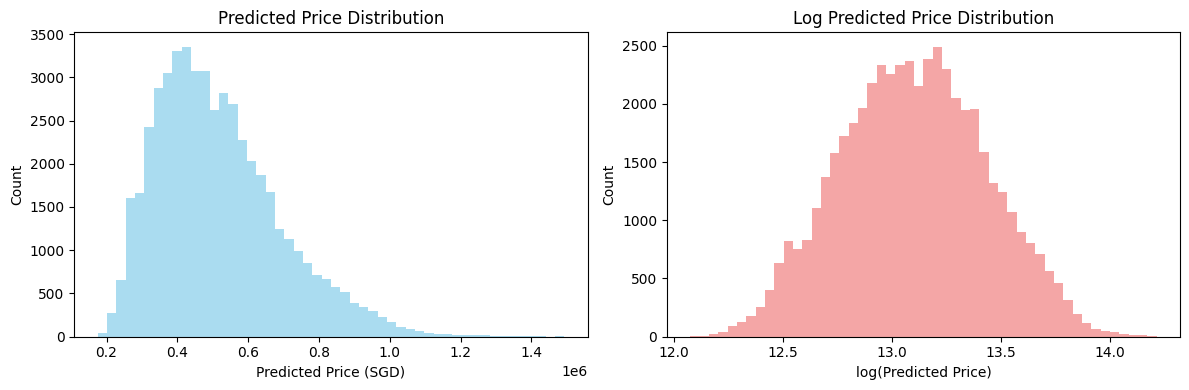

In [6]:
# Check and visualize predictions
# Lazy imports to ensure self-contained execution
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if 'predictions' not in globals() or 'X_test' not in globals():
    raise RuntimeError("Please run the previous cell first to generate predictions.")

submission = pd.DataFrame({'id': range(len(predictions)), 'Predicted': predictions})
print(f"Num predictions: {len(predictions)}")
print(f"Predicted price range: {predictions.min():.0f} - {predictions.max():.0f}")

print(f"\nPrediction summary:")
print(f"Mean predicted price: {predictions.mean():.0f} SGD")
print(f"Median predicted price: {np.median(predictions):.0f} SGD")
print(f"Std of predicted price: {predictions.std():.0f} SGD")

print(f"\nFirst 10 predictions:")
print(submission.head(10))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(predictions, bins=50, alpha=0.7, color='skyblue')
plt.title('Predicted Price Distribution')
plt.xlabel('Predicted Price (SGD)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(np.log(predictions), bins=50, alpha=0.7, color='lightcoral')
plt.title('Log Predicted Price Distribution')
plt.xlabel('log(Predicted Price)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [7]:
# Validate encoding rules
print("=== Encoding Rules Validation ===")

if 'pre_df_geo' not in globals() or 'df_test' not in globals():
    raise RuntimeError("Please run the test prediction cell first to create pre_df_geo and df_test.")

df_test_processed = pre_df_geo.copy()

print("TOWN encoding distribution:")
print(df_test_processed['TOWN_ENCODED'].value_counts().sort_index())

print("\nFLAT_TYPE encoding distribution:")
print(df_test_processed['FLAT_TYPE_ENCODED'].value_counts().sort_index())

if 'FLAT_MODEL_ENCODED' in df_test_processed.columns:
    print("\nFLAT_MODEL encoding distribution:")
    print(df_test_processed['FLAT_MODEL_ENCODED'].value_counts().sort_index())
else:
    print("\nNote: This pipeline did not produce FLAT_MODEL_ENCODED; skipped its distribution.")

print("\nUnencoded values check:")
print(f"TOWN unencoded count: {int(df_test_processed['TOWN_ENCODED'].isnull().sum())}")
print(f"FLAT_TYPE unencoded count: {int(df_test_processed['FLAT_TYPE_ENCODED'].isnull().sum())}")
if 'FLAT_MODEL_ENCODED' in df_test_processed.columns:
    print(f"FLAT_MODEL unencoded count: {int(df_test_processed['FLAT_MODEL_ENCODED'].isnull().sum())}")

print("\nRaw test data samples:")
if 'df_test' in globals():
    cols_show = [c for c in ['TOWN','FLAT_TYPE','FLAT_MODEL'] if c in df_test.columns]
    print(df_test[cols_show].head(10))

print("\nEncoded test data samples:")
cols_to_show = [c for c in ['TOWN_ENCODED', 'FLAT_TYPE_ENCODED', 'FLAT_MODEL_ENCODED'] if c in df_test_processed.columns]
print(df_test_processed[cols_to_show].head(10))


=== Encoding Rules Validation ===
TOWN encoding distribution:
TOWN_ENCODED
1     2075
2     2635
3      864
4     2011
5     1947
6     1765
7      118
8      381
9     2253
10    1115
11    1222
12    2600
13     974
14    3293
15    1508
16     305
17    1398
18    3637
19    1390
20    1509
21    4132
22     911
23    3435
24    1588
25    3586
26    3348
Name: count, dtype: int64

FLAT_TYPE encoding distribution:
FLAT_TYPE_ENCODED
1        21
2      1002
3     11992
4     21126
5     12232
10     3611
11       16
Name: count, dtype: int64

Note: This pipeline did not produce FLAT_MODEL_ENCODED; skipped its distribution.

Unencoded values check:
TOWN unencoded count: 0
FLAT_TYPE unencoded count: 0

Raw test data samples:
            TOWN FLAT_TYPE  FLAT_MODEL
0      sembawang    3 room     model a
1    bukit merah    4 room     model a
2         bishan    3 room    improved
3        hougang    4 room  simplified
4  bukit panjang    4 room     model a
5        punggol    5-room    im

## 9. Model Summary


In [8]:
print("=== Random Forest Summary ===")

# Get cross-validation metrics from CV cell
if 'cv_out' not in globals():
    raise RuntimeError("Please run the cross-validation cell first to create cv_out.")

rmse_vals = -cv_out['test_rmse']
mae_vals = -cv_out['test_mae']
r2_vals = cv_out['test_r2']

cv_rmse = float(np.mean(rmse_vals))
cv_mae = float(np.mean(mae_vals))
cv_r2 = float(np.mean(r2_vals))

print(f"CV RMSE: {cv_rmse:.2f}")
print(f"CV MAE: {cv_mae:.2f}")
print(f"CV R²: {cv_r2:.4f}")

# Get feature importance from final model
if 'final_rf' not in globals() or 'X' not in globals():
    raise RuntimeError("Please run the cross-validation cell first to create final_rf and X.")

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 5 features:")
for i, (_, row) in enumerate(feature_importance.head(5).iterrows()):
    print(f"{i+1}. {row['feature']}: {row['importance']:.4f}")


=== Random Forest Summary ===
CV RMSE: 30709.28
CV MAE: 21340.35
CV R²: 0.9719

Top 5 features:
1. FLOOR_AREA_SQM: 0.2204
2. FLAT_TYPE_ENCODED: 0.1656
3. YEAR: 0.1442
4. DIST_TO_NEAREST_HAWKER_M: 0.0905
5. LEASE_COMMENCE_DATA: 0.0892
